Case 0:
  Continuous Solution - Value: 1.02057, Penalty: -0.00000, Score: 1.02058
  Exact Solution - Value: 1.02057, Penalty: 0.00000, Score: 1.02057
  Qaoa Solution - Value: 1.02057, Penalty: 0.00000, Score: 1.02057

Case 1:
  Continuous Solution - Value: 1.47478, Penalty: 57.61549, Score: -56.14071
  Exact Solution - Value: 1.48257, Penalty: 0.00000, Score: 1.48257
  Qaoa Solution - Value: 1.48257, Penalty: 0.00000, Score: 1.48257

Case 2:
  Continuous Solution - Value: 2.09796, Penalty: 2.82544, Score: -0.72748
  Exact Solution - Value: 2.09796, Penalty: 0.02825, Score: 2.06970
  Qaoa Solution - Value: -68.53343, Penalty: 0.24260, Score: -68.77603

Case 3:
  Continuous Solution - Value: 1.97051, Penalty: 0.38106, Score: 1.58945
  Exact Solution - Value: 1.97051, Penalty: 0.00381, Score: 1.96670
  Qaoa Solution - Value: -1.64037, Penalty: 0.06725, Score: -1.70762

Case 4:
  Continuous Solution - Value: 0.94786, Penalty: 0.73096, Score: 0.21690
  Exact Solution - Value: 0.94786, Penal

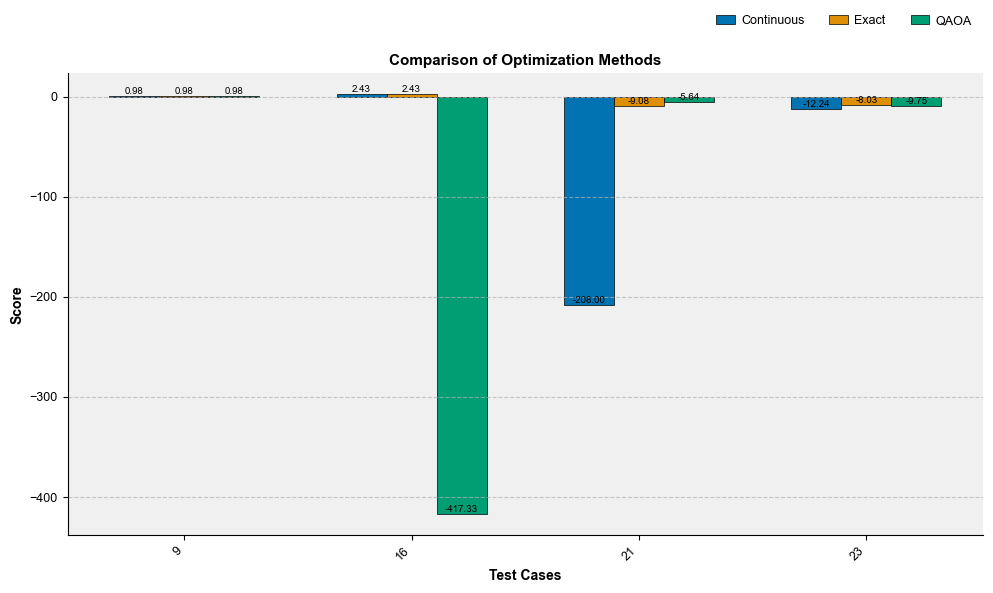

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    

def compare_solutions(data):
    results = {}
    
    for case_id, case_data in data.items():
        cont_sol = case_data.get("continuous_variables_solution", {})
        exact_sol = case_data.get("exact_solution", {})
        qaoa_sol = case_data.get("qaoa_solution", {})
        budget = case_data["hyperparams"]["budget"]
        penalizer = 0.01
        
        cont_value = cont_sol.get("value", 0)
        cont_penalty = cont_sol.get("left_overs", 0)
        
        exact_budgets = exact_sol.get("result_with_budget", [])[0]
        exact_value = exact_budgets.get("objective_value", 0)
        exact_penalty = penalizer*abs(exact_budgets["difference"])
        
        qaoa_value = qaoa_sol.get("objective_values", [])[-1]
        qaoa_budgets = qaoa_sol.get("result_with_budget", [])[-1]
        qaoa_penalty = penalizer*abs(qaoa_budgets["difference"])

        results[case_id] = {
            "continuous": {"value": cont_value, "penalty": cont_penalty, "score": cont_value - cont_penalty},
            "exact": {"value": exact_value, "penalty": exact_penalty, "score": exact_value - exact_penalty},
            "qaoa": {"value": qaoa_value, "penalty": qaoa_penalty, "score": qaoa_value - qaoa_penalty}
        }
    
    return results

def plot_scores(results, save_path=None, dpi=300, fig_width=10, fig_height=6):
    """
    Creates a publication-quality bar plot comparing scores across different methods.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing the results for each case and method.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.
    dpi : int, optional
        Resolution of the saved figure in dots per inch.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    
    Returns:
    --------
    fig, ax : tuple
        Figure and axes objects for further customization if needed.
    """
    
    # Set publication-quality parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 9,
        'axes.linewidth': 0.8,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'legend.frameon': False,
        'legend.handlelength': 1.5,
        'legend.handletextpad': 0.5
    })
    
    # Extract data
    cases = list(results.keys())
    continuous_scores = [results[case]["continuous"]["score"] for case in cases]
    exact_scores = [results[case]["exact"]["score"] for case in cases]
    qaoa_scores = [results[case]["qaoa"]["score"] for case in cases]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Set smoke gray background for plotting area
    ax.set_facecolor('#f0f0f0')  # Light smoke gray
    
    # Define bar positions
    x = np.arange(len(cases))
    width = 0.22
    
    # Define a professional color palette (colorblind-friendly)
    colors = ['#0173B2', '#DE8F05', '#029E73']
    
    # Plot bars with error bars if available
    cont_bars = ax.bar(x - width, continuous_scores, width, label="Continuous", 
                        color=colors[0], edgecolor='black', linewidth=0.5)
    exact_bars = ax.bar(x, exact_scores, width, label="Exact", 
                         color=colors[1], edgecolor='black', linewidth=0.5)
    qaoa_bars = ax.bar(x + width, qaoa_scores, width, label="QAOA", 
                        color=colors[2], edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02*max(continuous_scores + exact_scores + qaoa_scores),
                    f'{height:.2f}', ha='center', va='bottom', fontsize=7)
    
    add_value_labels(cont_bars)
    add_value_labels(exact_bars)
    add_value_labels(qaoa_bars)
    
    # Customize axes
    ax.set_xlabel("Test Cases", fontweight='bold')
    ax.set_ylabel("Score", fontweight='bold')
    ax.set_title("Comparison of Optimization Methods", fontweight='bold', fontsize=11)
    
    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(cases, rotation=45, ha='right')
    
    # Add grid lines for y-axis only, behind the bars
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend in optimal position
    ax.legend(loc='upper right', ncol=3, bbox_to_anchor=(1, 1.15))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    return fig, ax

def main():
    file_path = "portfolio_optimization_results.json"  # Update with actual path
    data = load_json(file_path)
    results = compare_solutions(data)
    
    for case, comparison in results.items():
        print(f"Case {case}:")
        for method, values in comparison.items():
            print(f"  {method.capitalize()} Solution - Value: {values['value']:.5f}, Penalty: {values['penalty']:.5f}, Score: {values['score']:.5f}")
        print()
    
    subset_of_results = {}
    for key in list(results.keys()):
        assets_to_qubits = data[key]["hyperparams"]["assets_to_qubits"]
        n_qubits = sum([len(v) for v in assets_to_qubits.values()])
        if n_qubits == 6:
            subset_of_results[key] = results[key]
    
    plot_scores(subset_of_results)

main()

In [2]:
file_path = "experiments_data.json"
data = load_json(file_path)["data"]
print(json.dumps(data[20], indent=4))


{
    "max_qubits": 4,
    "budget": 60.14999771118164,
    "stock_metadata": {
        "BA": {
            "max_int": 3,
            "qubits": 2,
            "random_int": 0,
            "price": 177.0
        },
        "INTC": {
            "max_int": 3,
            "qubits": 2,
            "random_int": 3,
            "price": 20.049999237060547
        }
    },
    "stocks": [
        "BA",
        "INTC"
    ],
    "start": "2015-01-01",
    "end": "2025-01-01",
    "n_stocks": 2
}


In [3]:
file_path = "portfolio_optimization_results.json"  # Update with actual path
data = load_json(file_path)
print(json.dumps(data["20"], indent=4))

{
    "hyperparams": {
        "stocks": [
            "BA",
            "INTC"
        ],
        "start": "2015-01-01",
        "end": "2025-01-01",
        "risk_aversion": 0.1,
        "max_qubits": 15,
        "budget": 60.14999771118164,
        "log_encoding": true,
        "layers": 5,
        "prices_now": {
            "BA": 177.0,
            "INTC": 20.049999237060547
        },
        "assets_to_qubits": {
            "BA": [
                0
            ],
            "INTC": [
                1,
                2
            ]
        }
    },
    "continuous_variables_solution": {
        "weights": {
            "BA": 0.7601938710932576,
            "INTC": 0.23980612890674227
        },
        "allocation": {
            "INTC": 2,
            "BA": 0
        },
        "value": 0.8329889845157504,
        "left_overs": 20.049999105973356
    },
    "exact_solution": {
        "smallest_eigenvalues": [
            -0.13051722191097745
        ],
        "smallest_b